In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install gdown
!pip install textstat
# !pip install sgnlp
!pip install spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 56.4 MB/s eta 0:00:00


**Feature Extraction**

In [2]:
import pandas as pd
import json
from tqdm import tqdm
# import textstat
# import spacy

def JsonToDataFrame(filePath):
  texts = []
  labels = []
  models = []
  ids = []
  sources = []


  dct = {'text': texts, 'model': models,"label":labels,"source":sources, "id":ids }
  with open(filePath, "r") as f:
    for line in f:
      curr = json.loads(line)
      texts.append(curr['text'])
      labels.append(curr['label'])
      models.append(curr['model'])
      sources.append(curr['source'])
      ids.append(curr['id'])


  df = pd.DataFrame(dct)
  return df

def data_stats(df):
  print("[INFO]: Unique AI models in dataset: ", df['model'].unique())
  print("[INFO]: Unique AI models in dataset: ", df['label'].unique())

def save_to_csv(df, outputPATH):
  df.to_csv("SubtaskA_dev_Monolingual.csv", index = False)


def get_corpuses(data):
  ai_corpus = set()
  human_corpus = set()

  for i in tqdm(range(len(data))):
    text = data['text'].iloc[i]
    if data['label'].iloc[i] ==0:
      for t in text.split(" "):
        human_corpus.add(t)
    else:
      for t in text.split(" "):
        ai_corpus.add(t)

  return ai_corpus, human_corpus


def complexity_of_sentence(sent):
  ## score between 1 to 100 (100 easiest , 1 hardest)
  return textstat.smog_index(sent)

def length_of_sentence(sent, nlp):
  tokens = nlp(sent)
  return len(tokens)

# def topic_modeling(sent):
#   pass

def spelling_errors(sent):
  pass

def emoji(sent):
  pass

def coherence(sent, preprocessor):
  sent_tensor = preprocessor([sent])

  return model.get_main_score(sent_tensor["tokenized_texts"]).item()


**Reading Data**

In [5]:
train_data = pd.read_csv("/content/drive/MyDrive/SharedTask/coherence_data_with_length_and_complexity.csv")
train_data.head()

,text,model,label,source,id,coherence,complexity,length
0,". Yasuo Ōtsuka (大塚 康雄 Ōtsuka Yasuo, born Febru...",davinci,1,wikipedia,12996,18.012884,13.2,444
1,\nWe present a detailed study of the inner reg...,cohere,1,arxiv,33734,9.027633,13.7,182
2,The two most popular sports in America in the...,cohere,1,reddit,56228,22.171431,13.9,402
3,Open your iMovie program and select either a p...,dolly,1,wikihow,52940,7.956687,9.5,185
4,\nThis paper addresses the problem of training...,cohere,1,peerread,46630,14.839405,16.3,85


Shuffle the data

In [6]:
train_data = train_data.sample(frac = 1)

In [ ]:
complexities = []
nlp = spacy.load('en_core_web_sm')
lengths = []

for i in tqdm(range(len(train_data))):
  text = train_data['text'].iloc[i]
  complexities.append(complexity_of_sentence(text))
  lengths.append(length_of_sentence(text, nlp))

train_data['complexity'] = complexities
train_data['length'] = lengths

 46%|████▌     | 55236/119757 [1:20:18<1:07:55, 15.83it/s]

In [ ]:
train_data.to_csv("/content/drive/MyDrive/SharedTask/coherence_data_with_length.csv", index = False)

In [ ]:
X = (train_data['text'], train_data['length'])
y = train_data['label']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.sparse import hstack

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train[0])
X_train_tfidf_with_length = hstack([X_train_tfidf, X_train[1]])
# X_train_modified = np.hstack(X_train_tfidf, )
X_test_tfidf = vectorizer.transform(X_test[0])
X_test_tfidf_with_length = hstack([X_test_tfidf, X_test[1]])

**Added custom features (Line 6 and 9) (above)**

In [ ]:
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
# from sklearn.naive_bayes import MultinomialNB
# from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.ensemble import ExtraTreesClassifier
# from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
# from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
lg = LogisticRegression(penalty='l1',solver='liblinear')
# sv = SVC(kernel='sigmoid',gamma=1.0)
# mnb = MultinomialNB()
# dtc = DecisionTreeClassifier(max_depth=5)
knn = KNeighborsClassifier()
# rfc = RandomForestClassifier(n_estimators=50,random_state=2)
# etc = ExtraTreesClassifier(n_estimators=50,random_state=2)
# abc = AdaBoostClassifier(n_estimators=50,random_state=2)
bg = BaggingClassifier(n_estimators=50,random_state=2)
# gbc = GradientBoostingClassifier(n_estimators=50,random_state=2)

In [ ]:
import sklearn.metrics as metrics
import pickle

def prediction(model,X_train,X_test,y_train,y_test, model_name):
    model.fit(X_train,y_train)
    pr = model.predict(X_test)
    pickle.dump(model, open('/content/drive/MyDrive/SharedTask/Models/' + model_name + '.pkl', 'wb'))
    acc_score = metrics.accuracy_score(y_test,pr)
    f1= metrics.f1_score(y_test,pr,average="binary", pos_label=1)
    return acc_score,f1

acc_score = {}
f1_score={}
clfs= {
    'LR':lg,
    'BG':bg,
    'KNN':knn
}
for name,clf in clfs.items():
    acc_score[name],f1_score[name]= prediction(clf,X_train_tfidf_with_length,X_test_tfidf_with_length,y_train,y_test, name)

    #View those scores
    print(acc_score)
    print(f1_score)

## Dev Data test

In [ ]:
dev_data = pd.read_csv("/content/drive/MyDrive/SharedTask/SubtaskA_dev_Monolingual.csv")
dev_data.head()

,text,model,label,source,id
0,Giving gifts should always be enjoyable. Howe...,bloomz,1,wikihow,0
1,Yveltal (Japanese: ユベルタル) is one of the main a...,bloomz,1,wikihow,1
2,If you'd rather not annoy others by being rude...,bloomz,1,wikihow,2
3,If you're interested in visiting gravesite(s) ...,bloomz,1,wikihow,3
4,The following are some tips for becoming succe...,bloomz,1,wikihow,4


Logistic Regression

In [ ]:
dev_tfidf = vectorizer.transform(dev_data['text'])
lg.fit(X_train_tfidf,y_train)
metrics.accuracy_score(lg.predict(dev_tfidf), dev_data['label'])

0.5712

Bagging Classifier

In [ ]:
bg.fit(X_train_tfidf,y_train)
metrics.accuracy_score(bg.predict(dev_tfidf), dev_data['label'])

In [ ]:
print("Number of words that are in AI corpus but not in Human Corpus: ", len(ai_corpus.difference(human_corpus)))
print("Number of words in AI corpus: ",len(ai_corpus))
print("Number of words in Human corpus: ",len(human_corpus))

581888

In [ ]:
import pandas as pd
df = pd.read_csv("/content/Sampled_50000.csv")

In [ ]:
df.head()

,text,model,label,source,id,coherence
0,Keep your hair messy. Wear a simple full-sleev...,dolly,1,wikihow,51487,-2.956827
1,\nThe Nazis thought that people of Asian desce...,cohere,1,reddit,53876,14.709232
2,"Koupaki, Phocis may refer to: Mount Koupaki, a...",dolly,1,wikipedia,6984,14.979999
3,II Riigikogu was the second legislature of Est...,human,0,wikipedia,84910,6.612170
4,Zeppelins were a type of rigid airship that we...,chatGPT,1,reddit,15418,19.593193


In [8]:
df = train_data

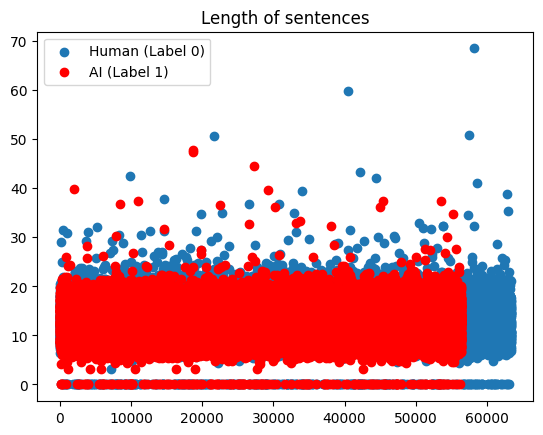

In [16]:
import matplotlib.pyplot as plt
data1= list(df[df['label'] == 0]['complexity'])
data2= list(df[df['label'] == 1]['complexity'])
plt.scatter( range(len(data1)), data1,  label='Human (Label 0)')
plt.scatter(range(len(data2)), data2, color='r', label='AI (Label 1)')
plt.title("Length of sentences")
plt.legend()

plt.show()

In [ ]:
df[df['label'] == 0]['coherence'].mean()

3.624400702703672

In [ ]:
df[df['label'] == 1]['coherence'].mean()

12.756321342689636